# Linear regression: Multiple variables with Regularization

This notebook is an extension to <a href="multiple_variables.ipynb"> Linear Regresssion: Multiple Variables </a> notebook. Please refer to it before reading this. We will enhance the solution by performing regularization while calculating the values of $\theta$.

## What is regularization?
Regularization is a technique to improve the generalization of a model. For a given set of training examples, there are an infinite number of curves that can fit, most of which are overcomplicated - having too many curves and angles. These kind of overcompilcated models don't usually generalize well to new examples outside the training set. This problem is called "overfitting". It is also called "High variance problem".

<img src = "https://upload.wikimedia.org/wikipedia/commons/f/fd/75hwQ.jpg" />

On the other extreme, we have something called as "underfitting" or "High bias problem", in which the curve in question is too rigid.

In the above figure, the green and blue functions both incur zero loss on the given data points. A learned model can be induced to prefer the green function, which may generalize better to more points drawn from the underlying unknown distribution. With regularization we attempt to solve the problem of overfitting by introducing a regularization term to the cost function, which essentially penalizes high values of $\theta$, keeping the variance of the model managable.

## The new cost function

The new cost function look like this:

$$
J = \frac {1}{2m} \sum_{i=1}^{m} [h_\theta(x^{(i)}) - y^{(i)}]^2 + \frac \lambda {2m} \sum_{j = 1}^n \theta^2
$$

where $\lambda$ is a variable to control the amount of regularization.

Note that if we introduce an intercept term $x_0$ and its corresponding $\theta_0$, we don't include $\theta_0$ in the summation of $\theta$ because $x_0$ is a constant term.

The following code implements the new cost function:

In [96]:
# Hypothesis function
def hypothesisLinearRegression(theta, X):
    return np.dot(X, theta)

# Function to calculate cost for a given set of parameters (theta)
def costLinearRegressionReg(theta, X, y, lmbda):
    m = X.shape[0]
    diff = hypothesisLinearRegression(theta, X) - y
    cost = (1.0/(2 * m)) * (np.dot(diff.T, diff))
    theta_ = np.copy(theta)
    theta_[0][0] = 0;
    reg = (lmbda/(2 * m)) * np.dot(theta_.T, theta_)
    cost = cost + reg;
    return cost[0]

## Regularized Gradient Descent

Since we have a new cost function, the gradient function will also be different. The new gradient descent algorithm is:

repeat till convergence: {
$$
\begin{align}
\theta_0 := \theta_0 - \alpha \left(\frac 1m \sum_{1=1}^m ( h_\theta(x^{(i)}) - y^{(i)}).x_0^{(i)}\right) \\
\theta_1 := \theta_0 - \alpha \left(\frac 1m \sum_{1=1}^m ( h_\theta(x^{(i)}) - y^{(i)}).x_1^{(i)} + \frac \lambda m \theta_1\right) \\
\theta_2 := \theta_0 - \alpha \left(\frac 1m \sum_{1=1}^m ( h_\theta(x^{(i)}) - y^{(i)}).x_2^{(i)} + \frac \lambda m \theta_2\right) \\
\vdots \\
\theta_n := \theta_0 - \alpha \left(\frac 1m \sum_{1=1}^m ( h_\theta(x^{(i)}) - y^{(i)}).x_n^{(i)} + \frac \lambda m \theta_n\right) \\
\end{align}
$$
}

The following is our new gradient descent algorithm implemented:

In [97]:
def gradientDescentReg(theta, X, y, alpha, num_iters, lmbda):
    m = X.shape[0]
    cost_history = [costLinearRegressionReg(theta, X, y, lmbda)]
    
    theta_ = np.copy(theta)
    theta_[0][0] = 0

    for i in range(1,num_iters):
        H = hypothesisLinearRegression(theta, X)
        D = H - y
        theta = theta - ( (alpha/m) * ( np.dot(D.T, X).T + (lmbda * theta_) ) )
        cost_history = np.append(cost_history, costLinearRegressionReg(theta, X, y, lmbda))
    
    return theta, cost_history

## Regularized Normal equation

Similar to gradient descent, we can also regularize our normal equation. The new equation is:

$$
\theta = (X^TX + \lambda L)^{-1}X^Ty
$$

where 
$$
L = \begin{bmatrix}
0 \\
& 1 \\
& & 1 \\
& & & \ddots \\
& & & & 1 \\
\end{bmatrix}
$$

$L$ is a matrix with 0 at the top and 1's for the rest of the diagonal and 0's everywhere else.

The following code implements our new normal equation:

In [98]:
def normalEquationReg(X, y, lmbda):
    from numpy.linalg import inv
    L = np.identity(X.shape[1])
    L[0][0] = 0
    
    theta= np.dot( np.dot( inv( np.dot(X.T, X) + (lmbda * L) ), X.T ), y )
    return theta

## Applying new algorithms on data

Following code applies our new regularized algorithms to the same data set that we used in <a href="multiple_variables.ipynb"> Linear Regresssion: Multiple Variables </a>

Output for gradient descent method:
Training error(160 examples) = [[ 1.4999024]]
Test error(40 examples) = [[ 8.90139916]]
Theta [[ 14.04592995]
 [  3.77603787]
 [  2.66416846]
 [  0.16285498]]

Output for normal equation method:
Training error(160 examples) = [[ 1.49880754]]
Test error(40 examples) = [[ 8.90758328]]
Theta [[ 14.07875   ]
 [  3.76423952]
 [  2.68378826]
 [  0.1303413 ]]


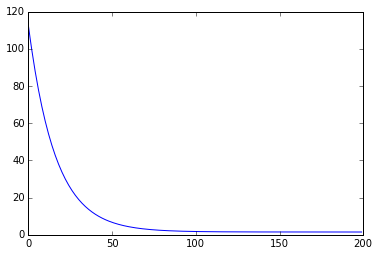

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing

%matplotlib inline

data = pd.read_csv('http://www-bcf.usc.edu/~gareth/ISL/Advertising.csv', index_col=0)

# Extract into separate matrices for input and output
data = np.matrix(data)
np.random.shuffle(data)

X = data[:,0:3]
y = data[:,3]

y = np.reshape(y, (y.shape[0], 1))

# Feature normalization
# Calculate xmax, xmin and xmean from values in X and pass to this function
def featureNormalize(X, xmax, xmin, xmean):
    xrange = xmax - xmin
    R = ( X - xmean ) / xrange
    R[ R != R ] = 0 # For cases where xrange value is 0, we get NaN in R
    return R

# Dividing data into two sets
# 1. Training set
# 2. Test set
# A good set of parameters should not only prove good for training set,
# but also for test set
total_size = X.shape[0]
training_set_size = int(total_size * (0.8))
test_set_size = total_size - training_set_size

Xtrain = X[0:training_set_size, :]
xmax = Xtrain.max(0)
xmin = Xtrain.min(0)
xmean = Xtrain.mean(0)
# XtrainNorm = featureNormalize(Xtrain, xmax, xmin, xmean)
XtrainNorm = preprocessing.scale(Xtrain.astype(np.float64))
XtrainNorm = np.append(np.ones((XtrainNorm.shape[0],1)), XtrainNorm, axis = 1)
ytrain = y[0:training_set_size]

Xtest = X[(training_set_size):(training_set_size + test_set_size), :]
XtestNorm = featureNormalize(Xtest, xmax, xmin, xmean)
XtestNorm = np.append(np.ones((XtestNorm.shape[0],1)), XtestNorm, axis = 1)
ytest = y[(training_set_size): (training_set_size + test_set_size)]

alpha = 0.03
num_iters = 200
lmbda = 1

theta_gd = np.zeros((X.shape[1] + 1, 1))
theta_gd, cost_history = gradientDescentReg(theta_gd, XtrainNorm, ytrain, alpha, num_iters, lmbda)

print("Output for gradient descent method:")
print ("Training error(" + str(training_set_size) + " examples) = " + str(costLinearRegressionReg(theta_gd, XtrainNorm, ytrain, lmbda)))
print ("Test error(" + str(test_set_size) + " examples) = " + str(costLinearRegressionReg(theta_gd, XtestNorm, ytest, lmbda)))
print ("Theta", theta_gd)

theta_ne = normalEquationReg(XtrainNorm, ytrain, lmbda)

print("\nOutput for normal equation method:")
print ("Training error(" + str(training_set_size) + " examples) = " + str(costLinearRegressionReg(theta_ne, XtrainNorm, ytrain, lmbda)))
print ("Test error(" + str(test_set_size) + " examples) = " + str(costLinearRegressionReg(theta_ne, XtestNorm, ytest, lmbda)))
print ("Theta", theta_ne)

plt.plot(cost_history)

It is expected to get lower values of $\theta$ components (except $\theta_0$) when using regularization